In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
monthly_data = pd.read_csv('returns.csv')

# Remove unwanted stock columns
columns_to_remove = ['ABBV', 'CAN', 'FB', 'GOOGL', 'LIN','META', 'TSLA']
monthly_data = monthly_data.drop(columns=columns_to_remove)

# Convert time column to datetime and set as index
monthly_data['Date'] = pd.to_datetime(monthly_data['Time'])
monthly_data = monthly_data.set_index('Date')

# Drop the now-unneeded Time column
monthly_data_numeric = monthly_data.drop(columns=['Time'])


/var/folders/yg/3swmh2bn7bj26rg7jzk_j2240000gn/T/ipykernel_51232/1644633714.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_data['Date'] = pd.to_datetime(monthly_data['Time'])


In [4]:
# Read and fix market cap data

marketcap_data = pd.read_csv('market_caps.csv')

# Get rid of both Grand Total column and Grand Total row
marketcap_data = marketcap_data.drop(columns=['Grand Total'])
marketcap_data = marketcap_data.drop(len(marketcap_data)-1)

# Change index to Date and put in proper format
marketcap_data['Date'] = pd.to_datetime(marketcap_data['Row Labels'])
marketcap_data = marketcap_data.set_index('Date')
marketcap_data = marketcap_data.drop(columns=['Row Labels'])


/var/folders/yg/3swmh2bn7bj26rg7jzk_j2240000gn/T/ipykernel_51232/4124939466.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  marketcap_data['Date'] = pd.to_datetime(marketcap_data['Row Labels'])


In [5]:
#Correlation Matrix Function
def make_correlation(start_idx, end_idx):
    df = monthly_data_numeric.iloc[start_idx:end_idx]
    
    X = df - df.mean()
    n = len(df)
    cov = (X.T @ X) / (n - 1)

    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    return pd.DataFrame(corr, index=df.columns, columns=df.columns)


In [6]:
#Gurobi Clustering with correlation matrix
from gurobipy import Model, GRB, quicksum

def gurobi_clustering(correlation_matrix, K):
    assets = correlation_matrix.columns.tolist()
    # Number of variables
    n = correlation_matrix.shape[0]
    # Create a new model
    m = Model("clustering")
    m.params.OutputFlag= 0
    # Create binary variables for each pair of variables
    x = m.addVars(n, n, vtype=GRB.BINARY, name="x")
    y = m.addVars(n, vtype=GRB.BINARY, name="y")
    # Objective: maximize the sum of correlations within clusters
    m.setObjective(quicksum(correlation_matrix.iloc[i, j] * x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)

    # Add constraints to ensure each variable is assigned to exactly one cluster
    for i in range(n):
        m.addConstr(quicksum(x[i, j] for j in range(n)) == 1, name=f"assign_{i}")

    #add constraint y_j = K
    m.addConstr(quicksum(y[j] for j in range(n)) == K, name=f"cluster_size")

    # x_ij <= y_j
    for i in range(n):
        for j in range(n):
            m.addConstr(x[i, j] <= y[j], name=f"link_{i}_{j}")

    # Optimize the model
    m.optimize()

    # Extract solution
    clusters = {}
    for j in range(n):
        if y[j].X > 0.5:  # j is a cluster representative
            primary = assets[j]
            clusters[primary] = [
                assets[i] for i in range(n) if x[i, j].X > 0.5
            ]
    return clusters

clusters = gurobi_clustering(make_correlation(0,120), 5)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2701666
Academic license 2701666 - for non-commercial use only - registered to hm___@rice.edu


In [ ]:
def compute_tracking_weights_gurobi(selected_assets, end_idx, window=120):
    """
    Compute variance-tracking weights for a subset of assets to match
    an equal-weighted benchmark across all assets.
    
    Parameters
    ----------
    selected_assets : list of str
        Subset of tickers to optimize weights for.
    end_idx : int
        Row index (exclusive) to end window.
    window : int
        Lookback window length.
    
    Returns
    -------
    dict
        Mapping {ticker: weight}.
    """
    import numpy as np
    import gurobipy as gp
    from gurobipy import GRB

    start_idx = end_idx - window

    # --- Full benchmark returns ---
    numeric_cols = monthly_data.select_dtypes(include=np.number).columns
    R_full = monthly_data.iloc[start_idx:end_idx][numeric_cols].astype(float).values
    T_full, K_full = R_full.shape

    # Equal-weight benchmark return vector
    w_bench_full = np.ones(K_full) / K_full
    r_bench_vec = R_full @ w_bench_full      # shape (T,)

    # --- Selected assets ---
    R = monthly_data.iloc[start_idx:end_idx][selected_assets].astype(float).values
    T, K = R.shape
    if T <= 1:
        raise ValueError(f"Not enough data points for window={window}")

    # ---------- Tracking-error QP ----------
    # Objective: min_w (1/2) w^T (2 R^T R) w  - (2 R^T r_bench)^T w
    Q = 2.0 * (R.T @ R)                       # Quadratic term
    c = -2.0 * (R.T @ r_bench_vec)            # Linear term

    # ---------- Solve with Gurobi ----------
    m = gp.Model("variance_tracking")
    m.Params.OutputFlag = 0

    w = m.addMVar(shape=K, lb=0.0, name="w")  # long-only; remove lb=0.0 for unconstrained
    m.setObjective(0.5 * w @ Q @ w + c @ w, GRB.MINIMIZE)

    m.addConstr(w.sum() == 1.0)

    m.optimize()

    if m.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        raise RuntimeError(f"Gurobi failed (status {m.Status})")

    return dict(zip(selected_assets, w.X))


In [ ]:
def compute_mv_weights(selected_assets, end_idx, window=120):
    import gurobipy as gp
    from gurobipy import GRB

    start_idx = end_idx - window

    R = monthly_data.iloc[start_idx:end_idx][selected_assets].astype(float).values
    T, K = R.shape

    mu    = R.mean(axis=0)                  # (K,)
    Sigma = np.cov(R, rowvar=False)         # (K, K)

    m = gp.Model("mv_portfolio")
    m.Params.OutputFlag = 0

    w = m.addMVar(shape=K, lb=0.0, name="w")

    # (1/2) w' Σ w  -  μ' w
    m.setObjective(0.5 * w @ Sigma @ w - mu @ w, GRB.MINIMIZE)

    m.addConstr(w.sum() == 1.0)
    m.optimize()

    if m.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        raise RuntimeError(f"Gurobi failed (status {m.Status})")

    return dict(zip(selected_assets, w.X))

In [8]:
# Calculate Returns
def calculate_return(weights, index):
    ret = 0
    for stock, weight in weights.items():
        column = monthly_data.columns.get_loc(stock)
        stock_ret = monthly_data.iloc[index, column]
        ret += stock_ret * weight
    return ret

def portfolio_growth(returns):
    balance = 1.0
    curve = [balance]
    for r in returns:
        balance *= (1 + r)
        curve.append(balance)
    return curve

def mse(returns1, returns2):
    n = len(returns1)
    error = 0
    for i in range(n):
        error += (returns1[i] - returns2[i])**2
    return error / n

In [10]:
def make_equal_weights(k, clusters):
    weights = {}
    for cluster in clusters.keys():
        weights[cluster] = 1/k
    return weights

def make_marketcap_weights(index, clusters):
    marketcap_weights = {}
    for cluster, stocks in clusters.items():
        total_cap = marketcap_data.iloc[index, :].sum()
        cluster_cap = 0
        for stock in stocks:
            column = marketcap_data.columns.get_loc(stock)
            cluster_cap += marketcap_data.iloc[index, column]
        marketcap_weights[cluster] = cluster_cap / total_cap
    return marketcap_weights


In [ ]:
# Baseline Equal-Weighted Portfolio
k_values = [5, 10, 20]
T = 120
N = monthly_data.shape[0]
start_return_idx = T + 1

baseline_equal_returns = []

for i in range(start_return_idx, N):
    start_idx = i - (T + 1)
    end_idx   = i - 1

    corr_mat    = make_correlation(start_idx, end_idx)
    clusters_43 = gurobi_clustering(corr_mat, 43)

    eq_w = make_equal_weights(43, clusters_43)
    baseline_equal_returns.append(calculate_return(eq_w, i))

baseline_equal_curve   = portfolio_growth(baseline_equal_returns)
baseline_equal_returns = np.array(baseline_equal_returns)

In [ ]:
results_tracking = {}
results_mv       = {}
all_results      = []
# Tracking and optimizing portfolio creation
for k in k_values:
    track_rets = []
    mv_rets    = []

    for i in range(start_return_idx, N):
        start_idx = i - (T + 1)
        end_idx   = i - 1

        corr_mat        = make_correlation(start_idx, end_idx)
        clusters        = gurobi_clustering(corr_mat, k)
        selected_assets = list(clusters.keys())

        # Tracking (replicating the equal-weight benchmark)
        track_w = compute_tracking_weights_gurobi(selected_assets, i, window=T)
        track_rets.append(calculate_return(track_w, i))

        # Mean-variance (optimizing risk/return of k assets)
        mv_w = compute_mv_weights(selected_assets, i, window=T)
        mv_rets.append(calculate_return(mv_w, i))

    track_error = mse(track_rets, baseline_equal_returns)
    mv_error    = mse(mv_rets,    baseline_equal_returns)

    all_results.append(pd.DataFrame({
        "Portfolio": ["Tracking", "Mean-Var"],
        "k":         [k, k],
        "MSE":       [track_error, mv_error]
    }))

    results_tracking[k] = portfolio_growth(track_rets)
    results_mv[k]       = portfolio_growth(mv_rets)

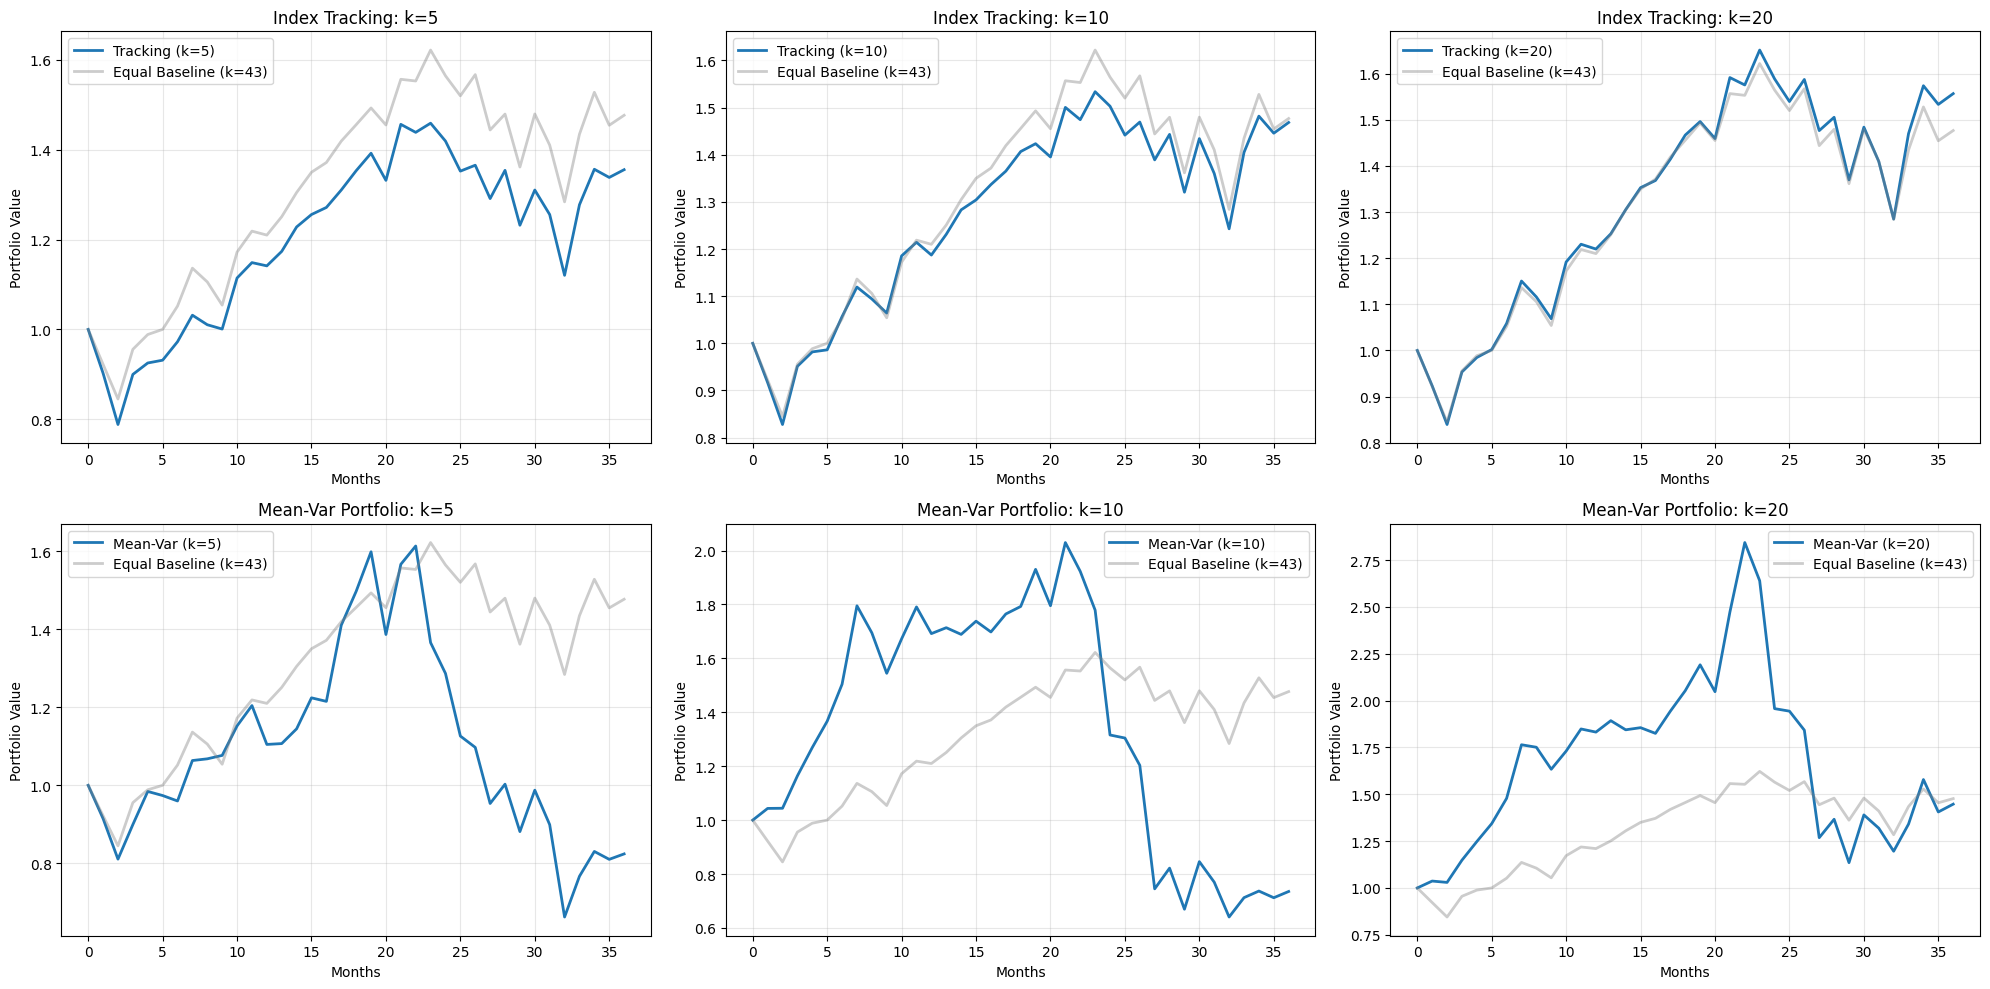


==================== MSE TABLE ====================
  Portfolio   k       MSE
0  Tracking   5  0.000314
1  Mean-Var   5  0.004244
2  Tracking  10  0.000156
3  Mean-Var  10  0.008165
4  Tracking  20  0.000069
5  Mean-Var  20  0.007531


In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.35)

for idx, k in enumerate(k_values):
    # --- Top row: Tracking ---
    ax = axes[0, idx]
    ax.plot(results_tracking[k],  label=f"Tracking (k={k})",        linewidth=2)
    ax.plot(baseline_equal_curve, label="Equal Baseline (k=43)", color="gray", alpha=0.4, linewidth=2)
    ax.set_title(f"Index Tracking: k={k}", fontsize=12)
    ax.set_xlabel("Months")
    ax.set_ylabel("Portfolio Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # --- Bottom row: Mean-Var ---
    ax = axes[1, idx]
    ax.plot(results_mv[k],        label=f"Mean-Var (k={k})",        linewidth=2)
    ax.plot(baseline_equal_curve, label="Equal Baseline (k=43)", color="gray", alpha=0.4, linewidth=2)
    ax.set_title(f"Mean-Var Portfolio: k={k}", fontsize=12)
    ax.set_xlabel("Months")
    ax.set_ylabel("Portfolio Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

df_all_results = pd.concat(all_results, ignore_index=True)
print("\n==================== MSE TABLE ====================")
print(df_all_results.round(6))